In [ ]:
!pip install datasets torch==2.3.0 torchtext==0.18.0 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.special import gamma


def mle(X: np.ndarray, k: int = 5, distances: bool = False):
    nn = NearestNeighbors(n_neighbors=k, metric='precomputed' if distances else 'minkowski').fit(X)
    dist, _ = nn.kneighbors()

    return (k - 1) / np.log(np.expand_dims(dist[:, -1], 1) / dist).sum(axis=-1)


def mle_aggregate(dim: np.ndarray):
    return 1 / np.mean(1 / dim)


def gaussian_kernel_one(x: float, n: float, sigma: float) -> float:
    return 1 / np.power(np.sqrt(2 * np.pi) * sigma, n) * np.exp(-x*x / 2 / sigma / sigma)


def unit_ball_volume(n: float) -> float:
    return np.sqrt(np.power(np.pi, n)) / gamma(n / 2 + 1)


def density(X: np.ndarray, k: int, dim: float, distances: bool = False) -> np.ndarray:
    nn = NearestNeighbors(n_neighbors=k, metric='precomputed'if distances else 'minkowski').fit(X)
    dist, _ = nn.kneighbors()
    h = np.power(np.arange(1, k + 1), -1 / (dim + 4))
    return np.sum(1 / np.power(h, k) / k * gaussian_kernel_one(dist / h, dim, 1) / k, axis=-1)


def mean_density(X: np.ndarray, k: int, dim: float, distances: bool = False) -> np.ndarray:
    nn = NearestNeighbors(n_neighbors=k, metric='precomputed' if distances else 'minkowski').fit(X)
    dist, ix = nn.kneighbors()
    rho = density(X, k, dim, distances)
    return np.arange(1, k + 1) / np.cumsum(1 / rho[ix], axis=-1)


def volume(X: np.ndarray, k: int, dim: float, distances: bool = False) -> np.ndarray:
    mu = mean_density(X, k, dim, distances)
    return np.arange(1, k + 1) / mu / (k - 1)


def quadratic_fit(X: np.ndarray, k: int, dim: float, distances: bool = False) -> np.ndarray:
    nn = NearestNeighbors(n_neighbors=k, metric='precomputed' if distances else 'minkowski').fit(X)
    dist, _ = nn.kneighbors()
    vol = volume(X, k, dim, distances)
    y = vol / unit_ball_volume(dim) / np.power(dist, dim)

    return 5 * np.sum(np.square(dist) * (y - 1) * np.diff(dist, prepend=0), axis=-1) / (dist[:, -1] ** 5 - dist[:, 0] ** 5)


def curvature(X: np.ndarray, k: int, dim: float = None, distances: bool = False) -> np.ndarray:
    dim = dim or mle_aggregate(mle(X, k, distances))
    return -6 * (dim + 2) * quadratic_fit(X, k, dim, distances)

In [ ]:
def lzw(s: str, abc: list, d: dict = None, ret_dict: bool = False):
    d = d or {x: i for i, x in enumerate(abc)}
    k = len(d)
    x = s[0]
    ret = ""
    for i in range(1, len(s)):
        y = s[i]
        if x + y in d:
            x = x + y
            continue
        ret += str(d[x])
        d[x + y] = k
        k += 1
        x = y
    ret += str(d[x])

    if ret_dict:
        return ret, d
    return ret


def lzw_conditional(s: str, t: str, abc: list, d: dict = None, ret_dict: bool = False):
    """Compression of s after t"""
    _, d = lzw(t, abc, d, ret_dict=True)
    ret, d = lzw(s, abc, d, ret_dict=True)
    if ret_dict:
        return ret, d
    return ret


def compression_complexity(s: str, abc: list):
    abc = abc + list('0123456789')
    return len(lzw(s, abc)) * np.log(len(abc)) / np.log(len(abc) - 10)


def conditional_compression_complexity(s: str, t: str, abc: list):
    """C(s | t)"""
    abc = abc + list('0123456789')
    return len(lzw_conditional(s, t, abc)) * np.log(len(abc)) / np.log(len(abc) - 10)


def batch_compression_curvature(X: list[str], abc: list, k: int = 5):
    ind = np.array([compression_complexity(s, abc) for s in X], dtype=float)
    cross = np.array([[conditional_compression_complexity(s, t, abc) for t in X] for s in X], dtype=float)
    X = np.minimum(cross, cross.T) / np.maximum(ind.reshape(-1, 1), ind.reshape(1, -1))
    X -= np.diag(np.diag(X))
    return curvature(X, k, distances=True)


def batch_complexity(X: list[str], abc: list):
    return np.array([
        compression_complexity(s, abc) for s in X
    ])

In [ ]:
from datasets import load_dataset

train_iter = load_dataset("sh0416/ag_news", split='train')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/33.7M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

labels = [s['label'] - 1 for s in train_iter]

sss = StratifiedShuffleSplit(n_splits=1, train_size=0.95, random_state=42)
trix, valix = next(sss.split(labels, labels))

In [ ]:
abc = set()
for t in train_iter:
  abc |= set(list(t['title']))
  abc |= set(list(t['description']))

abc = list(abc)
abc

['U',
 '4',
 'v',
 'N',
 '?',
 '(',
 'V',
 'T',
 'Y',
 'R',
 'F',
 'i',
 'G',
 '8',
 'Q',
 'w',
 '$',
 'y',
 '!',
 'n',
 'z',
 '*',
 '.',
 '&',
 'W',
 'E',
 ')',
 '9',
 '6',
 'C',
 'p',
 ',',
 'h',
 'K',
 'q',
 'k',
 '-',
 'P',
 'b',
 '#',
 's',
 'A',
 'Z',
 ' ',
 'L',
 '5',
 't',
 'H',
 '=',
 '\\',
 '3',
 'I',
 'd',
 'f',
 '"',
 'l',
 'J',
 "'",
 ';',
 'o',
 'm',
 'M',
 'B',
 'X',
 '2',
 'j',
 'c',
 'D',
 'a',
 'S',
 'O',
 '1',
 '0',
 '_',
 '7',
 'e',
 ':',
 'u',
 '/',
 'x',
 'r',
 'g']

In [ ]:
len(abc)

82

In [ ]:
import torch
from itertools import combinations, cycle


class TextDatasetCorr(torch.utils.data.Dataset):
  def __init__(self, data_iter, index, Ncorr, Kcorr=2):
    super().__init__()

    p = np.random.permutation(len(index))
    self.labels = (np.array(data_iter[index]['label']) - 1)[p]
    self.texts = (np.array(data_iter[index]['title']) + ' ' + np.array(data_iter[index]['description']))[p]

    pools = tuple(cycle(self.texts[self.labels == l]) for l in range(self.labels.max() + 1))
    combs = combinations(range(len(pools)), Kcorr)
    res = []
    resy = []

    for ix in combs:
      for _ in range(Ncorr):
        sample_text = ' '.join([next(pools[i]) for i in ix])
        for i in ix:
          res.append(sample_text)
          resy.append(i)

    self.texts, self.labels = np.array(res), np.array(resy)
    self.complexities = np.array([compression_complexity(str(t), abc) for t in self.texts])


  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.texts[idx], self.labels[idx], self.complexities[idx]


class TextDataset(torch.utils.data.Dataset):
  def __init__(self, data_iter, index):
    super().__init__()
    self.labels = (np.array(data_iter[index]['label']) - 1)
    self.texts = (np.array(data_iter[index]['title']) + ' ' + np.array(data_iter[index]['description']))
    self.complexities = np.array([compression_complexity(str(t), abc) for t in self.texts])

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.texts[idx], self.labels[idx], self.complexities[idx]

In [ ]:
def add_to_class(Class):
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

@add_to_class(TextDatasetCorr)
def __getitem__(self, idx):
    return self.texts[idx], self.labels[idx], self.complexities[idx]

@add_to_class(TextDataset)
def __getitem__(self, idx):
    return self.texts[idx], self.labels[idx], self.complexities[idx]

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.05, random_state=42)
noncorr_trix, _ = next(sss.split(labels, labels))
train_dataset3 = TextDatasetCorr(train_iter, trix, 8000, 3)
train_dataset4 = TextDatasetCorr(train_iter, trix, 8000, 4)
train_dataset0 = TextDataset(train_iter, noncorr_trix)
train_dataset0.labels = np.concat([train_dataset0.labels, train_dataset3.labels, train_dataset4.labels])
train_dataset0.texts = np.concat([train_dataset0.texts, train_dataset3.texts, train_dataset4.texts])
train_dataset0.complexities = np.concat([train_dataset0.complexities, train_dataset3.complexities, train_dataset4.complexities])
val_dataset = TextDataset(train_iter, valix)

In [ ]:
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab

tokenizer = get_tokenizer('basic_english')
counter = Counter()
for t in train_dataset0.texts:
    counter.update(tokenizer(t))
for t in val_dataset.texts:
    counter.update(tokenizer(t))
vocab = vocab(counter, min_freq=1)

text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

In [ ]:
text_pipeline('here is the an example')

[786, 255, 32, 53, 13392]

In [ ]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets, c = [], [], [0], []
    for t in batch:
        _label, _text = int(t[1]), str(t[0])
        c.append(t[2])
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)

    return label_list.to(device), text_list.to(device), offsets.to(device), torch.tensor(c).to(device)

In [ ]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [ ]:
num_class = 4
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [ ]:
import time
import torch.nn.functional as F

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets, c) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)

        weight = F.softmax(-c, dim=-1)
        loss = F.cross_entropy(predited_label, label, reduction='none') * weight

        loss.sum().backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets, c) in enumerate(dataloader):
            predited_label = model(text, offsets)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [ ]:
# With shuffled samples & KC weighting
# Hyperparameters
EPOCHS = 5 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_dataloader = DataLoader(train_dataset0, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/ 2094 batches | accuracy    0.256
| epoch   1 |  1000/ 2094 batches | accuracy    0.272
| epoch   1 |  1500/ 2094 batches | accuracy    0.288
| epoch   1 |  2000/ 2094 batches | accuracy    0.298
-----------------------------------------------------------
| end of epoch   1 | time: 78.69s | valid accuracy    0.680 
-----------------------------------------------------------
| epoch   2 |   500/ 2094 batches | accuracy    0.311
| epoch   2 |  1000/ 2094 batches | accuracy    0.316
| epoch   2 |  1500/ 2094 batches | accuracy    0.315
| epoch   2 |  2000/ 2094 batches | accuracy    0.320
-----------------------------------------------------------
| end of epoch   2 | time: 80.64s | valid accuracy    0.790 
-----------------------------------------------------------
| epoch   3 |   500/ 2094 batches | accuracy    0.323
| epoch   3 |  1000/ 2094 batches | accuracy    0.323
| epoch   3 |  1500/ 2094 batches | accuracy    0.328
| epoch   3 |  2000/ 2094 batches | accuracy

In [ ]:
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets, c) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)

        weight = 1/torch.log(c)
        weight /= weight.sum()
        loss = F.cross_entropy(predited_label, label, reduction='none') * weight

        loss.sum().backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [ ]:
# With shuffled samples & KC weighting
# Hyperparameters
EPOCHS = 5 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_dataloader = DataLoader(train_dataset0, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/ 2094 batches | accuracy    0.263
| epoch   1 |  1000/ 2094 batches | accuracy    0.280
| epoch   1 |  1500/ 2094 batches | accuracy    0.297
| epoch   1 |  2000/ 2094 batches | accuracy    0.306
-----------------------------------------------------------
| end of epoch   1 | time: 81.52s | valid accuracy    0.706 
-----------------------------------------------------------
| epoch   2 |   500/ 2094 batches | accuracy    0.316
| epoch   2 |  1000/ 2094 batches | accuracy    0.318
| epoch   2 |  1500/ 2094 batches | accuracy    0.315
| epoch   2 |  2000/ 2094 batches | accuracy    0.321
-----------------------------------------------------------
| end of epoch   2 | time: 80.99s | valid accuracy    0.826 
-----------------------------------------------------------
| epoch   3 |   500/ 2094 batches | accuracy    0.326
| epoch   3 |  1000/ 2094 batches | accuracy    0.326
| epoch   3 |  1500/ 2094 batches | accuracy    0.319
| epoch   3 |  2000/ 2094 batches | accuracy

In [ ]:
from datasets import load_dataset

text_pipeline = lambda x: [vocab[token] if token in vocab else 0 for token in tokenizer(x)]

test_iter = load_dataset("sh0416/ag_news", split='test')
test_dataset = TextDataset(test_iter, np.arange(len(test_iter)))
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
evaluate(test_dataloader)

0.8686842105263158

In [ ]:
torch.save(model, 'corruptedKC.pt')

In [ ]:
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets, c) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)

        weight = (c.max() - c)/(c.max() - c.min())
        weight /= weight.sum()
        loss = F.cross_entropy(predited_label, label, reduction='none') * weight

        loss.sum().backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [ ]:
# With shuffled samples & KC weighting
# Hyperparameters
EPOCHS = 5 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_dataloader = DataLoader(train_dataset0, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()# With shuffled samples & KC weighting
# Hyperparameters
EPOCHS = 5 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_dataloader = DataLoader(train_dataset0, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/ 2094 batches | accuracy    0.264
| epoch   1 |  1000/ 2094 batches | accuracy    0.287
| epoch   1 |  1500/ 2094 batches | accuracy    0.303
| epoch   1 |  2000/ 2094 batches | accuracy    0.310
-----------------------------------------------------------
| end of epoch   1 | time: 96.35s | valid accuracy    0.786 
-----------------------------------------------------------
| epoch   2 |   500/ 2094 batches | accuracy    0.325
| epoch   2 |  1000/ 2094 batches | accuracy    0.319
| epoch   2 |  1500/ 2094 batches | accuracy    0.319
| epoch   2 |  2000/ 2094 batches | accuracy    0.319
-----------------------------------------------------------
| end of epoch   2 | time: 96.11s | valid accuracy    0.854 
-----------------------------------------------------------
| epoch   3 |   500/ 2094 batches | accuracy    0.326
| epoch   3 |  1000/ 2094 batches | accuracy    0.326
| epoch   3 |  1500/ 2094 batches | accuracy    0.327
| epoch   3 |  2000/ 2094 batches | accuracy

In [ ]:
from datasets import load_dataset

text_pipeline = lambda x: [vocab[token] if token in vocab else 0 for token in tokenizer(x)]

test_iter = load_dataset("sh0416/ag_news", split='test')
test_dataset = TextDataset(test_iter, np.arange(len(test_iter)))
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
evaluate(test_dataloader)

0.8713157894736843

In [ ]:
torch.save(model, 'corruptedKC.pt')

Text(0.5, 1.0, 'Test Dataset')

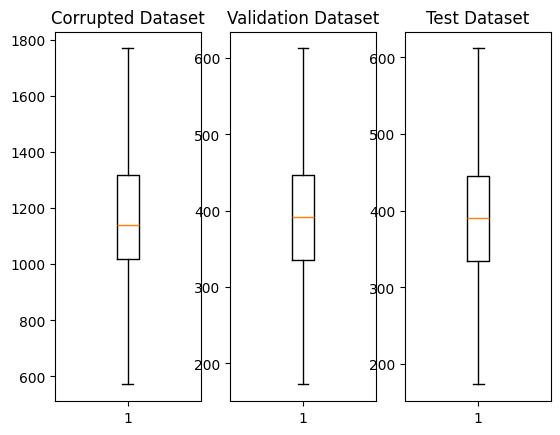

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Polygon

fig, axs = plt.subplots(1, 3)

axs[0].boxplot(train_dataset0.complexities, sym='')
axs[0].set_title("Corrupted Dataset")

axs[1].boxplot(val_dataset.complexities, sym='')
axs[1].set_title("Validation Dataset")

axs[2].boxplot(test_dataset.complexities, sym='')
axs[2].set_title("Test Dataset")

Text(0.5, 1.0, 'Corrupted & Validation & Test')

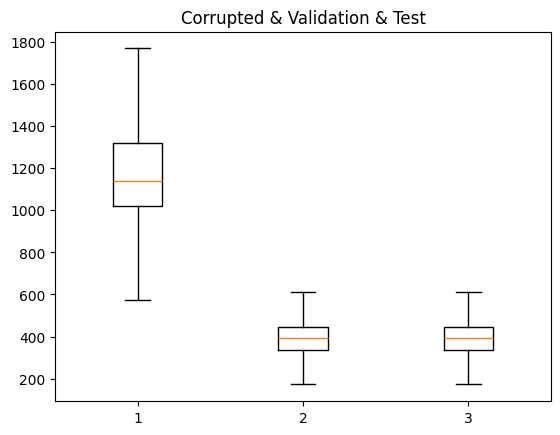

In [ ]:
data = [train_dataset0.complexities, val_dataset.complexities, test_dataset.complexities]

# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data, sym='')
plt.title('Corrupted & Validation & Test')

In [ ]:
train_dataloader = DataLoader(train_dataset0, batch_size=1, shuffle=False, collate_fn=collate_batch)
it = iter(train_dataloader)
next(it), next(it), next(it)

((tensor([0]),
  tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 19, 31,  0,  2, 32,
          33,  4,  2, 34,  5, 35, 36, 37,  5, 38,  5,  8, 39, 40, 41, 42, 43]),
  tensor([0]),
  tensor([478.1683], dtype=torch.float64)),
 (tensor([3]),
  tensor([44, 45, 46, 47, 48, 36, 49, 50, 51, 52, 26, 53, 46, 54, 43, 55, 56, 57,
          58, 19, 59, 60, 61, 62, 63, 64, 65, 19, 66, 67, 44, 57, 16, 68, 69, 70,
          71, 72, 19, 32, 73, 74, 43]),
  tensor([0]),
  tensor([421.7321], dtype=torch.float64)),
 (tensor([2]),
  tensor([ 75,  76,   5,  77,  78,  79,  13,  77,  19,  80,  26,  81,  82,  71,
           83,  84,  19,  85,  86,  87,  88,  89,   5,  90,  91,  21,  92,  93,
            5,  94,  93,  95,  32,  96,  97,  98,  71,  66,  99, 100, 101, 102,
          103, 104, 105,  43]),
  tensor([0]),
  tensor([448.4111], dtype=torch.float64)))

In [ ]:
train_dataset0.labels[:3], train_dataset0.complexities[:3]

(array([0, 3, 2]), array([478.16830587, 421.73213243, 448.41105078]))

In [ ]:
model.eval()
acc = []
for idx, (label, text, offsets, c) in enumerate(train_dataloader):
    predited_label = model(text, offsets)

    acc.append((predited_label.argmax(1) == label).sum().item())

In [ ]:
acc = np.array(acc, dtype=bool)

Text(0.5, 1.0, 'Corrupted Correct & Incorrect')

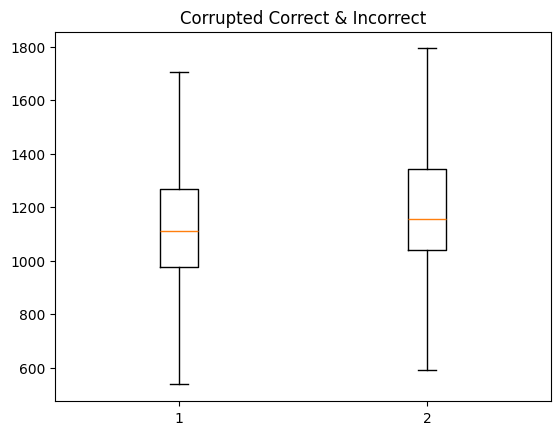

In [ ]:
data = [train_dataset0.complexities[acc], train_dataset0.complexities[~acc]]

# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data, sym='')
plt.title('Corrupted Correct & Incorrect')

In [ ]:
torch.save(model.state_dict(), 'corruptedKC.pt')

In [ ]:
train_dataset1 = TextDataset(train_iter, trix)

In [ ]:
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab

tokenizer = get_tokenizer('basic_english')
counter = Counter()
for t in train_dataset1.texts:
    counter.update(tokenizer(t))
for t in val_dataset.texts:
    counter.update(tokenizer(t))
for t in train_dataset0.texts:
    counter.update(tokenizer(t))
vocab2 = vocab(counter, min_freq=1)

text_pipeline = lambda x: [vocab2[token] for token in tokenizer(x)]

In [ ]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets, c = [], [], [0], []
    for t in batch:
        _label, _text = int(t[1]), str(t[0])
        c.append(t[2])
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)

    return label_list.to(device), text_list.to(device), offsets.to(device), torch.tensor(c).to(device)

In [ ]:
def train(dataloader):
    clean_model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets, c) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = clean_model(text, offsets)
        loss = F.cross_entropy(predited_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    clean_model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets, c) in enumerate(dataloader):
            predited_label = clean_model(text, offsets)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

clean_model = TextClassificationModel(len(vocab2), emsize, num_class).to(device)

In [ ]:
len(vocab2)

95810

In [ ]:
# Hyperparameters
EPOCHS = 5 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

optimizer = torch.optim.SGD(clean_model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_dataloader = DataLoader(train_dataset1, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/ 1782 batches | accuracy    0.715
| epoch   1 |  1000/ 1782 batches | accuracy    0.863
| epoch   1 |  1500/ 1782 batches | accuracy    0.882
-----------------------------------------------------------
| end of epoch   1 | time: 38.87s | valid accuracy    0.847 
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.900
| epoch   2 |  1000/ 1782 batches | accuracy    0.904
| epoch   2 |  1500/ 1782 batches | accuracy    0.907
-----------------------------------------------------------
| end of epoch   2 | time: 35.74s | valid accuracy    0.877 
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.921
| epoch   3 |  1000/ 1782 batches | accuracy    0.916
| epoch   3 |  1500/ 1782 batches | accuracy    0.916
-----------------------------------------------------------
| end of epoch   3 | time: 36.19s | valid accuracy    0.826 
-------------------------------

In [ ]:
clean_model.eval()
train_dataloader = DataLoader(train_dataset0, batch_size=1, shuffle=False, collate_fn=collate_batch)
acc_clean = []
for idx, (label, text, offsets, c) in enumerate(train_dataloader):
    predited_label = clean_model(text, offsets)

    acc_clean.append((predited_label.argmax(1) == label).sum().item())
acc_clean = np.array(acc_clean, dtype=bool)

Text(0.5, 1.0, 'Corrupted Correct & Incorrect')

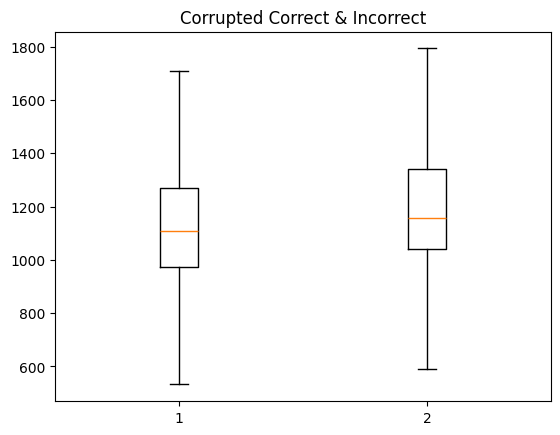

In [ ]:
data = [train_dataset0.complexities[acc_clean], train_dataset0.complexities[~acc_clean]]

# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data, sym='')
plt.title('Corrupted Correct & Incorrect')

In [ ]:
torch.save(clean_model.state_dict(), 'clean.pt')

In [ ]:
# train_dataset0.complexities = np.concat([train_dataset0.complexities, train_dataset3.complexities, train_dataset4.complexities])
n = len(train_dataset0)
lim = [(0, n - len(train_dataset4) - len(train_dataset3)), (n - len(train_dataset4) - len(train_dataset3), n - len(train_dataset4)), (n - len(train_dataset4), n)]

Text(0.5, 1.0, 'Correct & Incorrect in The Original Dataset')

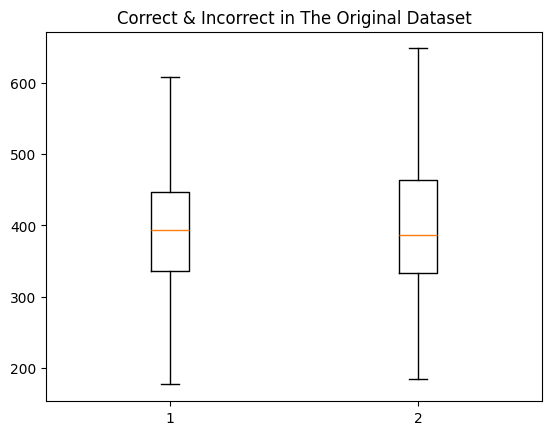

In [ ]:
data = [
    train_dataset0.complexities[lim[0][0]:lim[0][1]][acc_clean[lim[0][0]:lim[0][1]]],
    train_dataset0.complexities[lim[0][0]:lim[0][1]][~(acc_clean[lim[0][0]:lim[0][1]])]
]

# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data, sym='')
plt.title('Correct & Incorrect in The Original Dataset')